In this project, you will be working with the protein interaction network (PIN) of *Saccharomyces cerevisiae* from the BioGRID Multi-Validated (MV) Datasets. The nodes and edges of this PIN denote proteins and their physical interactions, respectively. These interactions have been identified from large-scale protein interaction experiments such as yeast two-hybrid screenings and affinity purification with mass spectrometry. Additionally, they pass a specific set of criteria as defined [here](https://wiki.thebiogrid.org/doku.php/biogrid_mv) (BioGRID MV Datasets). See the following [link](https://wiki.thebiogrid.org/doku.php/biogrid_tab_version_2.0) to familiarize yourself with the contents of this BioGRID file. You will be analyzing the yeast PIN using *k*-core analysis, and further use the network as a scaffold for incorporating gene expression data, allowing you to perform *s*-core analysis using pairwise gene expression correlations as weights.

### 1.1 Yeast protein interaction network

Download the file containing all multi-validated protein-protein interactions from BioGRID found on Blackboard `BioGRID_PIN.txt`. Create a network with NetworkX using the systematic names to set source and target nodes. These corresponds to the columns named `Systematic Name Interactor A` and `Systematic Name Interactor B`. Remove all self-edges from the network.

In [1]:
# Imports 
import pandas as pd
import numpy as np
import networkx as nx
from pyvis.network import Network


In [32]:
import sys
import os
path_ = sys.path[0].split("/")
os.chdir("/".join(path_[:-1]))
os.getcwd()
from SysBio_fun import *
os.chdir("/".join(path_))

In [3]:
# Read file:
df = pd.read_table("BioGRID_PIN.txt", sep="\t", low_memory=False)

# Define source and target column:
source = "Official Symbol Interactor A"
target = "Official Symbol Interactor B"
# Rename columns:
df.rename(columns={source:"source", 
                   target:"target"},
                   inplace=True)
# Drop rows where column "source" value is identical to column "target" value.
# I.e., drop self loops:
# **NB!** This the number of rows left in the df may vary depending on which
# column-pairs were treated as source-target. E.g. source:"-" and target:"-"
# will be removed, even though they may have different Entrez ID.
df = df[df["source"] != df["target"]]

# Generate the graph:
# **NB!** I treat the graph as multi directed, i.e. each row in the df
# amounts to a single edge in the network!
PIN = nx.from_pandas_edgelist(df, edge_attr=True, create_using=nx.MultiDiGraph())

# Make a copy
PIN_copy = PIN.copy() 



(i) How large is the network (i.e. number of nodes and edges), and what is the average node degree? 

In [4]:
N = PIN.number_of_nodes()
E = PIN.number_of_edges()
mean_k = (E*2)/N  # Average node degree. Each link contributes a degree "point" for each node it connects. Therefore 2*E

print(f"""
The number of nodes are: {N}
The number of edges are: {E}
The average node degree is: {mean_k} 
""")


The number of nodes are: 20550
The number of edges are: 245288
The average node degree is: 23.872311435523116 



(ii) Look up *S. cerevisiae* S288C in the NCBI Taxonomy Database [here](https://www.ncbi.nlm.nih.gov/taxonomy) and take note of the taxonomy ID. Using the `Organism Interactor A` and `Organism Interactor B` edge attributes in the network, use this taxonomy ID to filter out all non-*S. cerevisiae* S288C nodes from the network. Also, remove all self-loops and isolated nodes. How many nodes and edges remain? Create a plot of its degree distribution. How would you characterize this network and its degree distribution?

In [5]:
PIN = PIN_copy.copy()

# The taxonomic ID of S. cerevisiae S288C is: 559292

# Generate a list of edges that does not fit:
r1 = [edge for edge,tax \
      in nx.get_edge_attributes(PIN, "Organism Interactor A").items() \
          if tax != 559292]  # The edge information is a tuple and the key
r2 = [edge for edge,tax \
      in nx.get_edge_attributes(PIN, "Organism Interactor B").items() \
        if tax != 559292]
rem = set(r1+r2)  # set() is used to remove potential duplicates
# Use the list to remove all edges 
PIN.remove_edges_from(rem)
# In pandas:
# len(df[(df["Organism Interactor A"] == 559292) & (df["Organism Interactor B"] == 559292)])


# Remove nodes with a node degree of 0 (i.e. isolated nodes):
PIN.remove_nodes_from(  # Remove nodes from list ...
    [nodes for nodes,degree \
     in dict(PIN.degree()).items() if degree == 0]  # nodes with degree 0
)

N = PIN.number_of_nodes()  # New number of nodes
E = PIN.number_of_edges()  # New number of edges

print(f"""
The number of nodes is now {N},
while number of edges is {E}
""")


The number of nodes is now 4104,
while number of edges is 68704



(iii) Compare the yeast PIN with Barabási–Albert (BA) and Erdős–Rényi (ER) networks with approximately the same number of nodes and edges using a few selected network measurements and the degree distributions. Do these models do a good job in describing the yeast PIN? Discuss why/why not.

In [70]:
l_comp = nx.Graph(PIN.subgraph(
    sorted(
        nx.connected_components(
            nx.to_undirected(PIN.copy())
            #PIN.copy().to_undirected(as_view=True)
            ),
        reverse=True
    )[0]
).copy())

n = l_comp.number_of_nodes()
e = l_comp.number_of_edges()

ER = connected_ER(n, e)
BA = connected_BA(n, round(((e*2)/n)))


In [69]:
#type(PIN.subgraph(nx.connected_components(PIN.to_undirected())[0]))
type(
    nx.Graph(PIN.subgraph(
        sorted(
            nx.connected_components(
                nx.Graph(PIN.copy())
            ), reverse=True)[0]
        ))
    )
type(PIN)

# PIN2 = nx.Graph(PIN.copy())
# print(type(PIN2))
# print(PIN == PIN2)
# PIN2 = PIN2.to_undirected()
# print(type(PIN2))




networkx.classes.multidigraph.MultiDiGraph

In [71]:
graph_info(l_comp)
graph_info(ER)
graph_info(BA)

Number of nodes: 4022
Number of edges: 16700
Is connected:    True
Number of nodes: 4022
Number of edges: 16700
Is connected:    True
Number of nodes: 4022
Number of edges: 32112
Is connected:    True


<span style="color:blue">

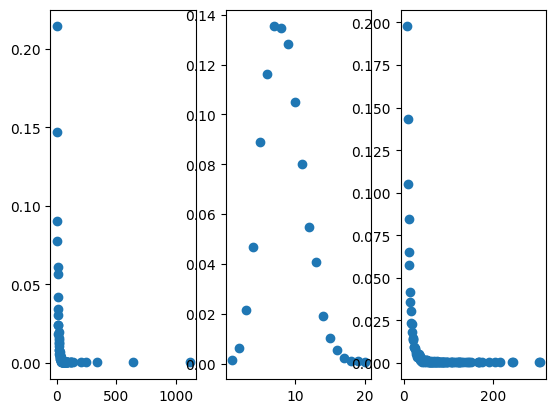

In [72]:

def degree_distribution(graph):
    """
    Function that returns a scatter plot of the degree
    distribution of a graph. 
    """
    N = graph.number_of_nodes()  # Total number of nodes
    y = np.array(nx.degree_histogram(graph))/N  # All occurrences of "n" degree, divided by total number of nodes
    x = np.arange(len(y))[y != 0]  # x values
    y = y[y != 0]  # Remove the values = 0 from the array
    
    return x, y

x_l_comp, y_l_comp = degree_distribution(l_comp)
x_ER, y_ER = degree_distribution(ER)
x_BA, y_BA = degree_distribution(BA)


figure, axis = plt.subplots(1, 3)
axis[0].scatter(x_l_comp, y_l_comp)
axis[1].scatter(x_ER, y_ER)
axis[2].scatter(x_BA, y_BA)

In [38]:
#plt.scatter(nx.clustering(BA).keys(), nx.clustering(BA).values())

(iv) You will now start peeling away layers of the yeast PIN by $k$-core analysis. In your own words, describe/define *k*-core analysis, and explain how it works on a network. What network does the 1-core correspond to?

<span style="color:blue">
k-core analysis is a method to 

(v) Calculate the 2-core of the yeast PIN. How large is this network? Plot and characterize its degree distribution and compare it to the original yeast PIN.

Number of nodes: 3102
Number of edges: 15780
Is connected:    True


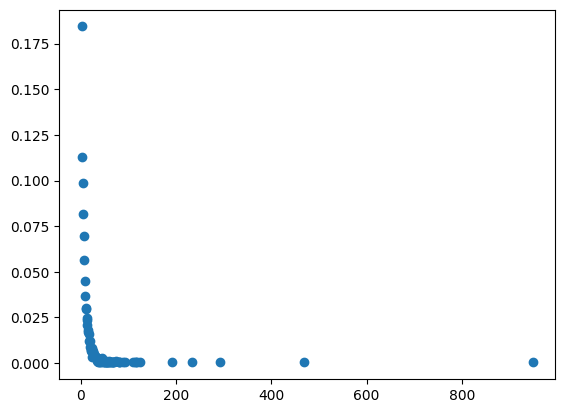

In [76]:
l_comp_2_core = nx.k_core(l_comp, k=2)
graph_info(l_comp_2_core)

x, y = degree_distribution(l_comp_2_core)
plt.scatter(x,y)

(vi)  Find the innermost *k*-core (the last *k* before the network is empty). How many edges and nodes are there in the innermost *k*-core? What is the absolute maximal amount of edges that there could be between this number of nodes, and how does the innermost core compare to that?

In [86]:
current_k = 0
g = l_comp.copy()
while nx.number_of_nodes(g) > 0:
    current_k += 1
    g = nx.k_core(g, k=current_k)
innermost_k_core = current_k-1

print(f"The innermost k-core is: {innermost_k_core}")

graph_info(nx.k_core(l_comp.copy(), k=innermost_k_core))

The innermost k-core is: 18
Number of nodes: 19
Number of edges: 171
Is connected:    True


(vii) Create a plot of the number of nodes and the number of edges in a *k*-core against *k*. How would you characterize this plot? What does it tell you?

In [87]:
y = [nx.number_of_nodes(nx.k_core(l_comp.copy(), k=k_)) for k_ in range(1, innermost_k_core+1)]
x = range(1, innermost_k_core+1)

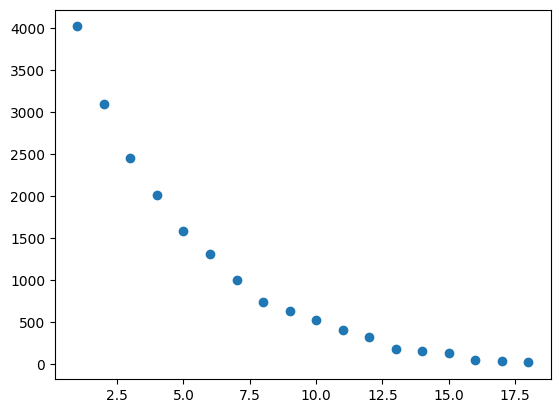

In [88]:
plt.scatter(x, y)

(viii) Generate the second innermost $k$-core and visualize it using pyvis. Describe the network.

In [ ]:
s = nx.k_core(l_comp.copy(), k=innermost_k_core-1)

(ix)  We will now load gene expression data onto our yeast PIN. Go to this [url](https://www.ebi.ac.uk/gxa/experiments/E-GEOD-20591/Results) containing the gene expression data set from *Transcription profiling by array of yeast to investigate expression of the beta-subunit of Snf1 kinase*. For those interested, you can find detailed information about the dataset in the original publication [here](https://onlinelibrary.wiley.com/doi/full/10.1111/j.1365-2958.2010.07209.x). Download `normalized_expressions.tsv` from Blackboard and import the list of gene names, as well as corresponding expression data from 24 experimental conditions. For all pairwise gene combinations, calculate the Pearson correlation coefficients and associated p-values for the *N* genes present in the yeast PIN (both as *N* x *N* Numpy arrays). Out of the gene pairs with positive correlation values, how many of them have a significance value below 0.0001?

(x) Download `s_core.py`. This is similar to the NetworkX function `k_core`, but uses node strength instead of node degree. Strength is defined as the sum of the weights of all the links attached to a node (i.e. Person correlations). With negative weights, the absolute values of the weights are used to calculate the strength. In this case, however, we are only looking at positively correlated nodes. Do you think it would make sense to include negative correlations in this particular case? Discuss.

(xi) Calculate the *s*-core with *s* = 2.5, 3, 3.5, and 4, and characterize their degree distributions. Discuss how the distribution changes for increasing values of *s*.

(xii) Find an integer value for *s* that gives as good match as possible relative to the second innermost *k*-core in terms of number of distinct modules and number of nodes. Visualize this *s*-core with pyvis and describe the network.

(xiii) Using the full yeast PIN network (network from (ii)), extract the nodes that are either part of the second innermost *k*-core, the *s*-core in (xii), or part of both cores. How many nodes and edges are there in this new network? Create a visualization of this subnetwork using pyvis, and color the nodes according to the following classifications:
- Red if it was only found in the second innermost *k*-core.
- Green if it was only found in the *s*-core.
- Blue if it was found in both.

Describe the network and discuss what you observe. Is it a single connected component? What do the differences between the *s*- and *k*-cores tell you?